<p style="text-align: center">
<img src="../../assets/images/dtlogo.png" alt="Duckietown" width="50%">
</p>

In [1]:
%matplotlib inline
import time
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display
import cv2
import copy
from tqdm.contrib import tzip

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Particle filter

The particle filter allows us to estimate the robot's state by tracking some set of likely states and updating these as we get new measurements. This is achieved using a set of particles, where each particle $i$ represents a hypothesis of the state state $x_t^i$ with its associated weight $w_t^i$. So for example, in the context of state estimation (e.g., localization), each particle represents how likely the robot is to be located at that particular state.

The algorithm is as follows. First, we initialize the particle filter by sampling $M$ particles. Usually the initial set of particles can be sampled uniformly from the set of all possible states (i.e., uniform sampling). Given a control signal $u_t$, we move all the particles (i.e., the state associated with each particle) that we currently have following the motion model. After this, we take a measurement $z_t$ (which we can get from our sensor) and update the weights of each particle based on how likely we are to measure $z_t$ if we were at the corresponding state of each particle (e.g., $p(z_t | x_i)$). We then resample all the particles, not uniformly, but according to the weights of each particle (i.e., the ones with higher weights are more likely to be sampled). This means that the particles that have higher weights will be sampled more often, while the ones with low weights may not be sampled at all. There are different options to obtain the predicted (i.e., filtered) state. In this notebook, we will do the simplest approach by taking the mean of the resampled particles.

We then repeat this process every time we have new $u_t$ and $z_t$. In practice, we may not know what $p(z_t|x_i)$ is, so we may need other ways to compute the particle weight. We will see this later in the implementation.

The above algorithm is the basic algorithm for the particle filter. There are some associated challenges and different algorithm variations try to address these issues. For example, if we implement the above algorithm, the performance will be largely affected by the initial set of particles because during resampling step, we only sample particles from the set of initial particles. Thus, it is possible that we may not even have particles that are near the correct state. This problem is sometimes known as particle depletion. To help alleviate this problem, during resampling step, instead of sampling completely from the set of particles that we currently have according to their weights, we can sample a small percentage of particles randomly from the set of all possible particles. 

Let's take a look at a concrete example.

## Example: estimating robot position with particle filter

Consider a robot moving in a room without obstacles. The robot is equipped with two sensors to measure distance between the robot and the walls, which allows the robot to measure the location of the robot (i.e., $x$ and $y$ positions) in the room. For the sake of simplicity, assume that the sensors directly provide us with a noisy measurement of the $(x,y)$ location in the room.

Say the state of the robot is its $x$ and $y$ position in the room, and the control inputs are the velocity in each direction $v_x$ and $v_y$. The robot is initialized at $(x,y) = (0,0)$, and moves by applying constant control inputs $v_x = v_y = 0.1$ for 100 time steps. At each time step, after applying a control signal, the robot can take a measurement using the sensors to have an idea where it currently is. 

We assume the motion model:

$$
x_t = x_{t-1} + u_t + w_t,
$$

where $w_t \sim \mathcal{N}([0, 0]^T,\sigma_R\mathcal{I}_2)$ ($\mathcal{I}_2$ is the $2x2$ identity matrix). Note that, unlike the Kalman filter, there is no requirement that the model be linear or have noise that is either additive or Gaussian. We are defining things this way to keep things simple. 

Let's also assume that the manufacturer of the sensor told us something about the performance of the sensor. That the measurements have zero mean and standard deviation $\sigma$. As a result the measurement model is:

$$ 
z_t = x_t + n_t
$$

where $n_t \sim \mathcal{N}([0, 0]^T,\sigma_Q\mathcal{I}_2$). Again note that we do not require the model to be structured this way in a particle filter but we do this for simplicty here. 

We will use the particle filter to improve our estimate of where the robot is at each time step.

### Understanding the problem

To understand the problem, let us plot the ideal trajectory and some possible measurements that we would get using the available sensors according to their specifications. In real life, we can get sensor measurements from our sensors. But here, to simulate sensor measurements, we will take the ground truth state at every time step and add some Gaussian noise from $\mathcal{N}(0, 0.5)$.

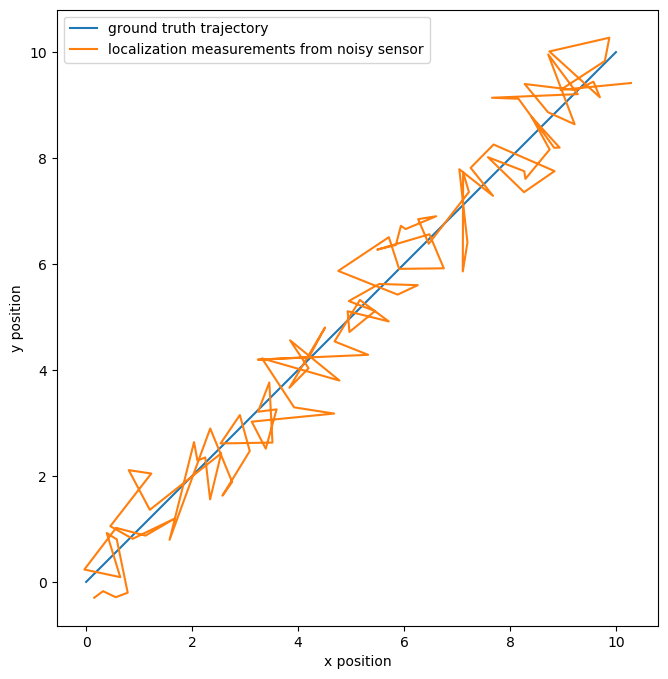

In [2]:
# state = [x_pos, y_pos]
num_data = 100 # this is the number of timesteps we will simulate for
ground_truth_x = np.linspace(0, 10, num=num_data + 1)
ground_truth_y = ground_truth_x.copy() # x = y
    
# Simulate sensor measurements
measurement_noise_x_var = 0.5 # these are the "ground truth" measurement covariances
measurement_noise_y_var = 0.5
noise_x = np.random.normal(loc=0.0, scale=measurement_noise_x_var, size=num_data-1)
noise_y = np.random.normal(loc=0.0, scale=measurement_noise_y_var, size=num_data-1)
measurement_x = np.linspace(10 / num_data, 10, num=num_data-1) + noise_x
measurement_y = np.linspace(10 / num_data, 10, num=num_data-1) + noise_y

# Compare ground truth and measurements
plt.figure(figsize=(8,8))
plt.plot(ground_truth_x, ground_truth_y)
plt.plot(measurement_x, measurement_y)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth trajectory', 'localization measurements from noisy sensor'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

As we can see there is quite a lot of noise coming from the sensor.

### Implementing particle filter 

First let's create a Particle class. Each particle should have a state and a weight. We also need a method for a particle to move given a control signal $u_t$ (i.e., predict step) and a method to update its own weight given a measurement $z_t$. We will also need a function later to sample a particle from a particle set while accounting for the weights.

In [3]:
# Let's define the covariances of our motion and measurement models (we can adjust these and see what happens)
import random
sigma_R = 0.01
sigma_Q = 0.5

In [4]:
class Particle():
    def __init__(self, x, y, w):
        self.state = np.array([x, y])
        self.weight = w
    
    def predict(self, u_t):
        # We need to sample the particle through the prediction function (will require sampling from the Gaussian)
        # For example, you could use the function scipy.stats.multivariate_normal(...).pdf(...)  - see documentation online
        noise = scipy.stats.multivariate_normal(mean=[0, 0], cov=sigma_R * np.eye(2)).rvs()
        self.state = self.state + u_t + noise # TODO - update this line
        
    def update(self, z_t):
        likelyhood = scipy.stats.multivariate_normal(mean=self.state, cov=sigma_Q*np.eye(2)).pdf(z_t)
        self.weight = self.weight * likelyhood # TODO - update this line

def sample_particle(particles):
    # TODO write this function to sample a particle based on the weights
    # You might need to normalize the weights to obtain a valid probabilty distribution function (i.e. the sum of the weights is 1)
    all_weights = [particle.weight for particle in particles]
    all_weights_np = np.array(all_weights)
    all_weights_np /= np.sum(all_weights_np)

    return particles[np.random.choice(len(particles), p=all_weights_np)]

Next, we implement the particle filter and run it for each time step.

In [5]:

num_particles = 100 # pick a number
alpha = 0.95

filtered_xs = []
filtered_ys = []
measurements = []
particles_over_time = []

# sample initial particles
particles = []

def initialize_particle():
    x = np.random.uniform(0, 10)
    y = np.random.uniform(0, 10)
    w = 1
    return Particle(x,y,w)

for i in range(num_particles):
    particles.append(initialize_particle())

# we assume constant control signal in this particular example
u_t = np.array([10./num_data, 10./num_data]) 
    
# run particle filter for each time step
for i in range(num_data):
    
    # given u_t, move all the particles following the motion model
    for p in particles:
        p.predict(u_t)
    
    # get measurement z_t (in real life, get this from our sensor instead)
    measurement_noise_x = np.random.normal(loc=0.0, scale=measurement_noise_x_var)
    measurement_noise_y = np.random.normal(loc=0.0, scale=measurement_noise_y_var)
    measurement_x_new = ground_truth_x[i+1] + measurement_noise_x
    measurement_y_new = ground_truth_x[i+1] + measurement_noise_y
    z_t = np.array([measurement_x_new, measurement_y_new])
    measurements.append([measurement_x_new, measurement_y_new])
    
    # given z_t, update particles' weights
    for p in particles:
        p.update(z_t)
    
    # store resampled particles so we can plot them later
    particles_over_time.append(copy.deepcopy(particles))

    
    new_particles = []
    for i in range(int(num_particles*alpha)):
        new_particle = copy.deepcopy(sample_particle(particles))
        new_particle.weight = 1
        new_particles.append(new_particle)
    for i in range(int(num_particles*(1-alpha))):
        new_particles.append(initialize_particle())
    
    particles = new_particles
        
    
        
    # get state estimate by taking the mean of the resampled particles (excluding the randomly sampled ones)
    xs = []
    ys = []
    for p in particles[:int(num_particles)]:
        xs.append(p.state[0])
        ys.append(p.state[1])
    estimated_x = np.mean(xs)
    estimated_y = np.mean(ys)
    
    # store filtered state so we can plot them later
    filtered_xs.append(estimated_x)
    filtered_ys.append(estimated_y)
    
measurements = np.array(measurements)

Let's visualize how the particles evolve over time so we can get a sense on how particle filter works.

In [6]:
ground_truth = np.stack((ground_truth_x, ground_truth_y), axis=1)
filtered_states = np.stack((filtered_xs, filtered_ys), axis=1)

In [7]:
# A pop-up may appear with the text "Widget require us to download supporting files from a 3rd party". Click the button 'Enable Downloads'.

plots = []

t = 0
for (set_of_ps, true_state, filtered_state, z_t) in tzip(particles_over_time, ground_truth[1:], filtered_states, measurements):
    fig = plt.figure()
    plt.scatter(true_state[0], true_state[1], color='blue', s=75)
    plt.scatter(filtered_state[0], filtered_state[1], color='green', s=75)
    plt.scatter(z_t[0], z_t[1], color='orange', s=75)
    
    for p in set_of_ps:
        plt.scatter(p.state[0], p.state[1], color='red', s=p.weight * 50)
    plt.title('time=%d, true (x,y)=(%.2f, %.2f) \n filtered (x,y)=(%.2f, %.2f)' 
              % (t+1, true_state[0], true_state[1], filtered_state[0], filtered_state[1]))
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.xlim(0,15)
    plt.ylim(0,15)
    plt.gca().set_aspect('equal', adjustable='box')
    
    blue_patch = patches.Patch(color='blue', label='true state')
    red_patch = patches.Patch(color='red', label='weighted particles')
    green_patch = patches.Patch(color='green', label='filtered state')
    orange_patch = patches.Patch(color='orange', label='noisy measurement')
    plt.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], loc='upper left', fontsize=8)
    
    fig.canvas.draw()
    plot_img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plots.append(plot_img)
    t += 1
    plt.clf()
    plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_4337/3604921312.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  plot_img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


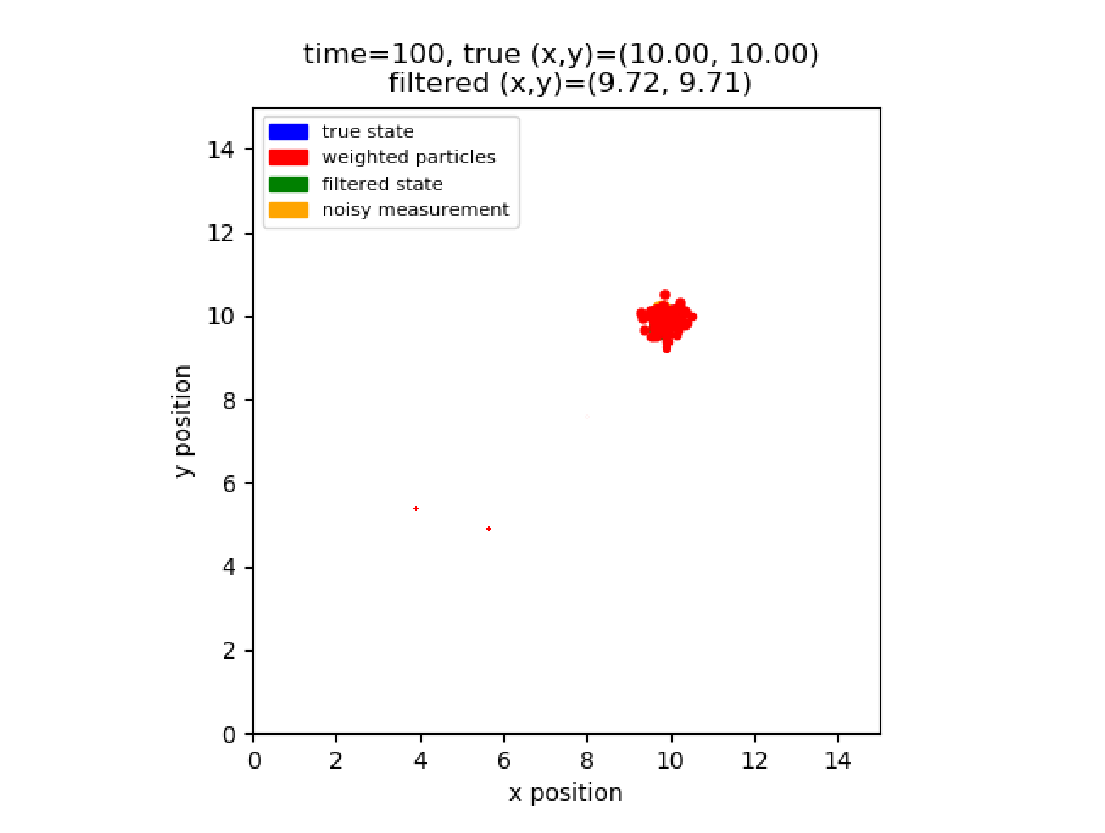

In [8]:
for im in plots:
    plt.figure(figsize=(14,14))
    plt.imshow(im)
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.1)
    plt.clf()
    plt.close()

In [9]:
# Run this if we want to save the plot animation as gif
# %pip install imageio
import imageio
imageio.mimsave('pf.gif', plots)

As we see, the particles (i.e., red dots) that are closer to where the robot is (i.e., blue dot) are getting bigger over time (i.e., gain more weight) as the robot moves. Here, the state predicted by the particle filter is visualized as the green dot, while the sensor measurement is visualized as the orange dot.

Notice that it takes some time for the particles to "converge" to the true state. This can be observed by looking at the poor performance at earlier time steps. This is because initially the particles were spawned randomly so it will not produce a good estimation until we have enough measurements. Let's plot the state estimation over time below.

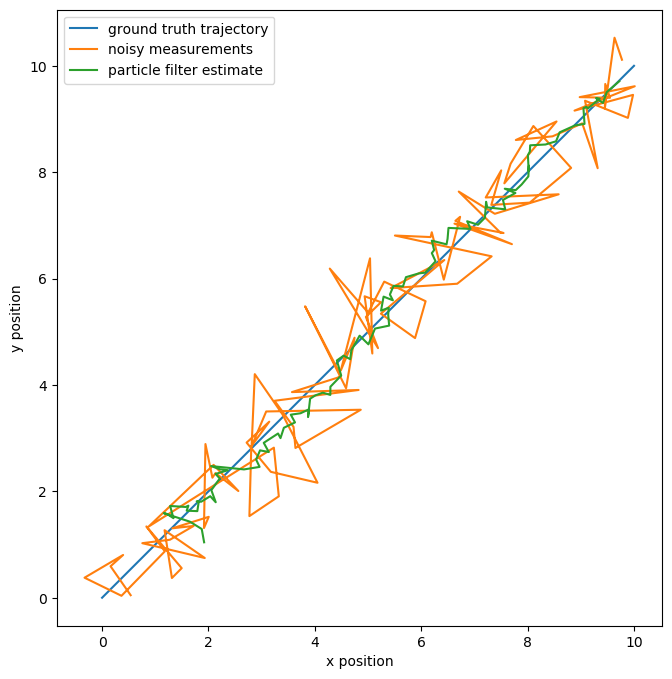

In [10]:
# Let's plot the results
plt.figure(figsize=(8,8))
plt.plot(ground_truth[:,0], ground_truth[:,1])
plt.plot(measurements[:,0], measurements[:,1])
plt.plot(filtered_states[:,0], filtered_states[:,1])
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth trajectory', 'noisy measurements', 'particle filter estimate'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The filter seems to work as the green lines is close to the $x=y$ line. What can we do to improve the performance even further?

While having more particles corresponds to better approximation of the true distribution that we are trying to estimate, it makes computation to be more expensive, so this can be a limitation depending on the hardware used. 

You may want to experiment with the parameters such as the number of particles or the $\alpha$ parameter to see if you can make things even better. 

Now we can move on to the final notebook on the [histogram filter](../03-histogram-filter/histogram_filter.ipynb).